In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.datasets.mnist import load_data
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam

# Este callback:
# - Monitorea la métrica 'accuracy' después de cada época
# - Si la precisión supera 0.95 (95%), detiene el entrenamiento
# - Útil para evitar entrenar más de lo necesario una vez alcanzado el objetivo
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True


In [5]:
# Cargar los datos MNIST y dividirlos en conjuntos de entrenamiento y prueba
(X_train, y_train), (X_test, y_test) = load_data()

In [7]:
# Obtener el tamaño del conjunto de entrenamiento 
n_train_size = X_train.shape[0]
n_train_size

60000

In [9]:
print("-"*50)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-"*50)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print("-"*50)

--------------------------------------------------
X_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
--------------------------------------------------
X_test shape:  (10000, 28, 28)
y_test shape:  (10000,)
--------------------------------------------------


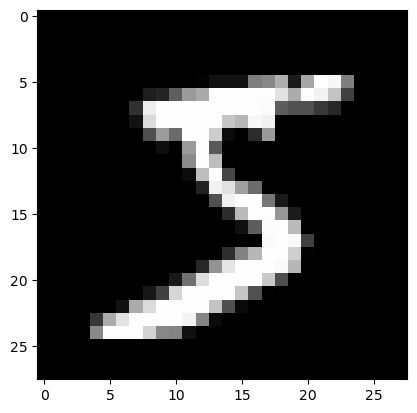

In [11]:
plt.imshow(X_train[0], cmap="gray")
plt.show()

In [ ]:
# Normalización de los datos
# Convertimos los valores de píxeles del rango [0-255] al rango [0-1]
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
# Después de esta normalización:
# - Los píxeles negros tendrán valores cercanos a 0
# - Los píxeles blancos tendrán valores cercanos a 1
# - Los tonos de gris tendrán valores entre 0 y 1

In [13]:
# Reshape de las imágenes para adaptarlas al formato esperado por la CNN
# El formato requerido es: (número_de_imágenes, altura, ancho, canales)
# -1 significa que calcule automáticamente el número de imágenes , por ejemplo 60.000
# 28, 28 son las dimensiones de cada imagen
# 1 indica un solo canal de color (escala de grises)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [15]:
print(y_train) #--> como son etiquetas de valores fuera de 0, 1 podriamos hacer one hot encoding

[5 0 4 ... 5 6 8]


In [19]:
idrop = 0.5
model = Sequential()

model.add(Conv2D(
    filters = 32,              # Número de filtros en la primera capa
    kernel_size = (3,3),
    padding="same",            # Padding para mantener las dimensiones espaciales
    activation = "relu",
    input_shape = (28, 28, 1)
))
model.add(MaxPooling2D(pool_size = (2,2)))  # Reduce dimensionalidad espacial a la mitad
model.add(Conv2D(
    filters = 64,              # Más filtros en la segunda capa
    kernel_size = (3,3),      
    padding="same",           
    activation = "relu"     
))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(idrop))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       3,212,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,241,354 (12.36 MB)

 Trainable params: 3,241,354 (12.36 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Tamaño del batch - número de muestras procesadas antes de actualizar el modelo
batch_size = 20    # Batches pequeños pueden dar mayor precisión pero entrenan más lento

# Tasa de aprendizaje - controla cuánto se ajustan los pesos en cada actualización
learning_rate = 0.0001    # Valor pequeño para un aprendizaje más estable pero más lento

# Número de épocas - cuántas veces se procesará el conjunto de datos completo
epochs = 100    # Suficientes épocas para permitir la convergencia

In [27]:
parada = myCallback()

# Compilar el modelo con el learning rate pasado como parámetro
model.compile(
   # Optimizador Adam con tasa de aprendizaje configurable
   optimizer = Adam(learning_rate = learning_rate),  
   loss = "sparse_categorical_crossentropy", 
   metrics = ["accuracy"]                    
)

In [29]:
# El entrenamiento:
# - Usa 80% de X_train/y_train para entrenamiento
# - Usa 20% de X_train/y_train para validación
# - Procesa los datos en batches de 20 imágenes
# - Puede ejecutar hasta 100 épocas (o menos si alcanza 95% de precisión)
# - Guarda el historial de métricas en la variable 'historico'
historico = model.fit(
   X_train,                    
   y_train,                 
   batch_size = batch_size,   
   epochs = epochs,       
   validation_split = 0.2, 
   callbacks = [parada],   
   verbose=0
)



Reached 95% accuracy so cancelling training!


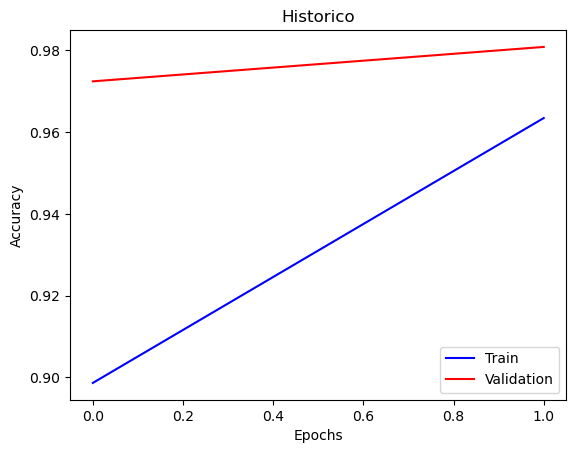

In [31]:
plt.plot(historico.history["accuracy"], c="b")
plt.plot(historico.history["val_accuracy"], c="r")
plt.title("Historico")          
plt.xlabel("Epochs")            
plt.ylabel("Accuracy")  
plt.legend(["Train", "Validation"])
plt.show()

In [33]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
ACC = model.evaluate(X_test, y_test)

# ACC[1] contiene la precisión (accuracy) ya que es la segunda métrica que definimos
# ACC[0] contendría el valor de la función de pérdida (loss)
print("Accuracy: ", ACC[1])

# La precisión en el conjunto de prueba es importante porque:
# - Representa el rendimiento real del modelo con datos nunca vistos
# - Es un mejor indicador de la capacidad de generalización que la precisión de entrenamiento
# - Ayuda a confirmar si hubo overfitting durante el entrenamiento

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9769 - loss: 0.0721
Accuracy:  0.9800999760627747
